In [2]:
import numpy as np
import pandas as pd

np.random.seed(23)

In [3]:
# Importing maindata

file_path = "C://Users//soren/Downloads/"

x = pd.read_stata(file_path + "maindata.dta", convert_categoricals=False)

# Importing laws_csv, cleaning it
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

In [4]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think
#age_subset = np.logical_and(np.greater_equal(basic_merged["a_age"],18), np.greater_equal(19,basic_merged["a_age"]))
# 17 <= age <= 21 (maybe should be like 22)
#basic_merged = basic_merged[age_subset]
#print(basic_merged.shape)

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# I also drop the never states, as they may be substantively different from others, although this can be relaxed later.
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to intbasic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("never")==False]  # Only want to look at one for now. 

# Drop Arizona since they implemented late and later repealed policy
basic_merged = basic_merged[basic_merged["stfips"] != 5]

# As we are treating >19 as the never-treated group, we set their year implemented as 1000000 >> 1999
year_implemented_vector = basic_merged["Year_Implemented"].copy()
year_implemented_vector[basic_merged["under19"] == 0] = 1000000
basic_merged["group"] = year_implemented_vector  # Equals the year you were first treated. If >=19 then treated at t = infty

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["fownu18", "a_maritl", "female" , "povll"]#, "stfips"]
list_of_confounders += ["anykids", "disability", "collgrad", "hsgrad"] # removed coll + hs for now 

C:\Users\soren\AppData\Local\Temp\ipykernel_27876\3995722855.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  confounder_df = basic_merged.groupby(by=["year"], as_index=False).mean().copy()[list_of_confounders + ["year"]]


<AxesSubplot: xlabel='Year', ylabel='Percent Increase from 1991'>

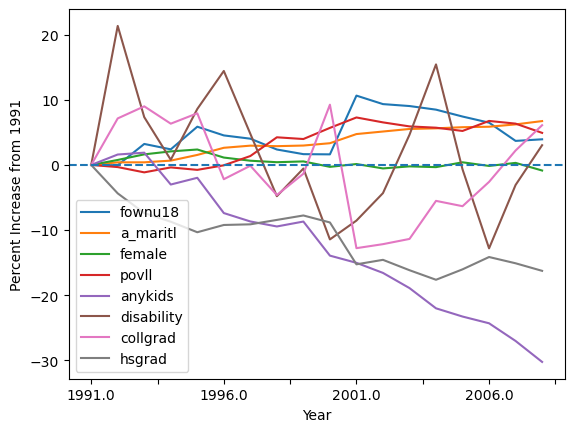

In [11]:
confounder_df = basic_merged.groupby(by=["year"], as_index=False).mean().copy()[list_of_confounders + ["year"]]
for confounder in list_of_confounders:
    confounder_df[confounder] = (confounder_df[confounder]/confounder_df[confounder_df["year"] == 1991][confounder][0] - 1) * 100

confounder_df["year"] = confounder_df["year"].apply(str)

ax = confounder_df.plot(x='year')
ax.set_xlabel("Year")
ax.set_ylabel("Percent Increase from 1991")
ax.axhline(0, linestyle='--')
ax